### Ce-bigFISH Image Analysis in batch

### 240808

#### Add conditional/interactive statement to choose between total abundance (whole embryo mask) or single cell detection (up to 4-cell stage embryos)

#### Modify output directory. Use outputs in image_output_directories to create report with all the quant output and software info

#### Rotate embryos according to body axis. Needed for the density plots, single cell detection and for the DV2PNG notebook


#### Input image info:

In [1]:
import os
import shutil

#import packages:
import matplotlib.pyplot as plt
import numpy as np

import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.multistack as multistack
import bigfish.detection as detection

import cellpose
from cellpose import models
import pandas as pd
import skimage
from skimage.measure import label, regionprops
from skimage.morphology import square, dilation, erosion
from skimage import measure, morphology

from IPython.display import display
import seaborn as sns



In [2]:
#specify where the directory of the data
local_download_directory = '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440'

#specify the molecules in each channel
Cy5 = "set-3_mRNA" #(asymmetrical control)
mCherry = "erm-1_mRNA" #(query mRNA)
FITC = "membrane" #(ignore in this case) This is where protein markers usually go.
DAPI = "DAPI"
brightfield = "brightfield"

#info about your microscope
wavelength_cy5 = 670 # emmision peak in nm
wavelength_mCherry = 610  # emmision peak in nm
na = 1.42  # numerical aperture of microscope
refractive_index_medium = 1.515 # oil refractive index



In [3]:
#Specify where the data will be stored
input_directory = os.path.join(local_download_directory, 'input')
# output_directory = '/projects/naly@colostate.edu/bigfish/temps'
output_directory = os.path.join(local_download_directory, 'output')
# output_dir = output_directory
folder_name = local_download_directory.split(os.path.sep)[-1]

# Get a list of subdirectories within local_download_directory
subdirectories = [item for item in sorted(os.listdir(input_directory)) if item != '.ipynb_checkpoints' if os.path.isdir(os.path.join(input_directory, item))]

# Iterate through the subdirectories and store their path in a list
subdirectory_paths = []
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(input_directory, subdirectory)
    subdirectory_paths.append(subdirectory_path)

# Iterate through each subdirectory path
all_image_stacks = []
all_files = []
for subdirectory_path in subdirectory_paths:
    files = [os.path.join(subdirectory_path, item) for item in os.listdir(subdirectory_path)]
    
    # Check if exactly 2 files with the specified names are present
    if len(files) == 2 and any(file.endswith("R3D_REF.dv") for file in files) and any(file.endswith("R3D.dv") for file in files):
        files = sorted(files)
        all_files.append(files)
        
        # Store all image stacks in a list
        subdirectory_image_stacks = []
        for file_path in files:
            image_stack = stack.read_dv(file_path, sanity_check=False)
            subdirectory_image_stacks.append(image_stack)
        all_image_stacks.append(subdirectory_image_stacks)
        
    else:
        print(f"corrupted: {subdirectory_path}")
        # Copy the entire corrupted directory to the 'corrupted_files' directory
        corrupted_path = os.path.join(local_download_directory, 'corrupted_files')
        corrupted_subdirectory = os.path.basename(subdirectory_path)
        corrupted_destination = os.path.join(corrupted_path, corrupted_subdirectory)
        shutil.move(subdirectory_path, corrupted_destination)
        continue

# Now, all_image_stacks contains the image data from all the .dv files, organized by subdirectory.
print(f'Images read: {len(all_image_stacks)}')

image_names = []

for file_pair in all_files:
    for file_path in file_pair:
        # Extract the filename without extension
        filename = os.path.splitext(os.path.basename(file_path))[0]
        # Extract the part before the last underscore
        image_name = filename.rsplit('_', 0)[0]
        # Add the image_name to the list if it's not already present and does not end with '_REF'
        if image_name not in image_names and not image_name.endswith('_REF'):
            image_names.append(image_name)

print(image_names)

Images read: 8
['240409_wLP017_L4440_02_R3D', '240409_wLP017_L4440_03_R3D', '240409_wLP017_L4440_04_R3D', '240409_wLP017_L4440_05_R3D', '240409_wLP017_L4440_07_R3D', '240409_wLP017_L4440_09_R3D', '240409_wLP017_L4440_10_R3D', '240409_wLP017_L4440_11_R3D']


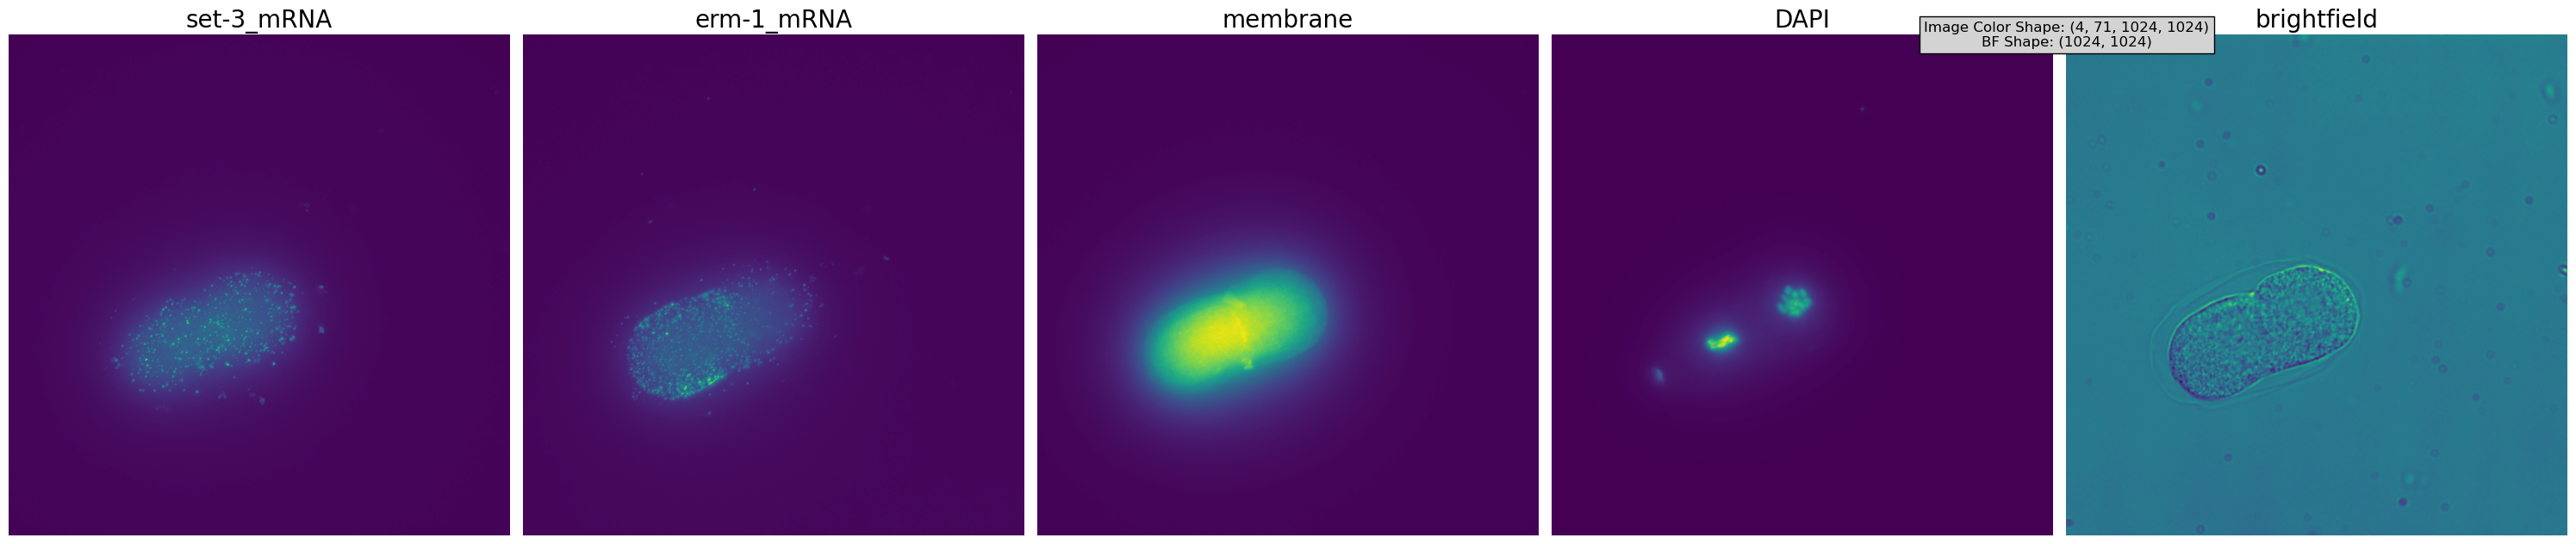

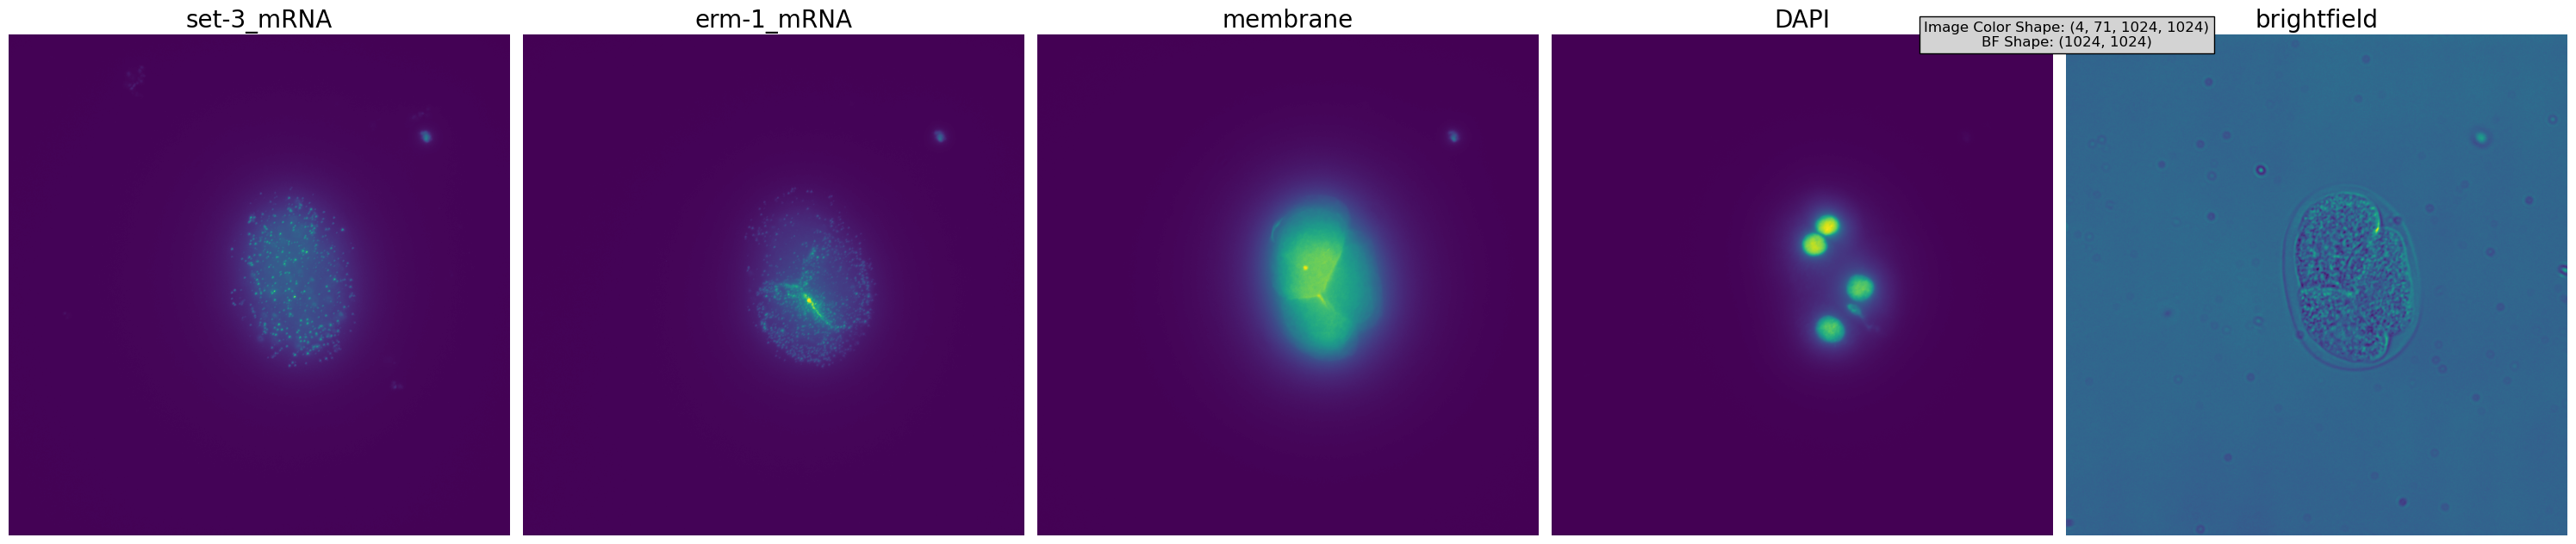

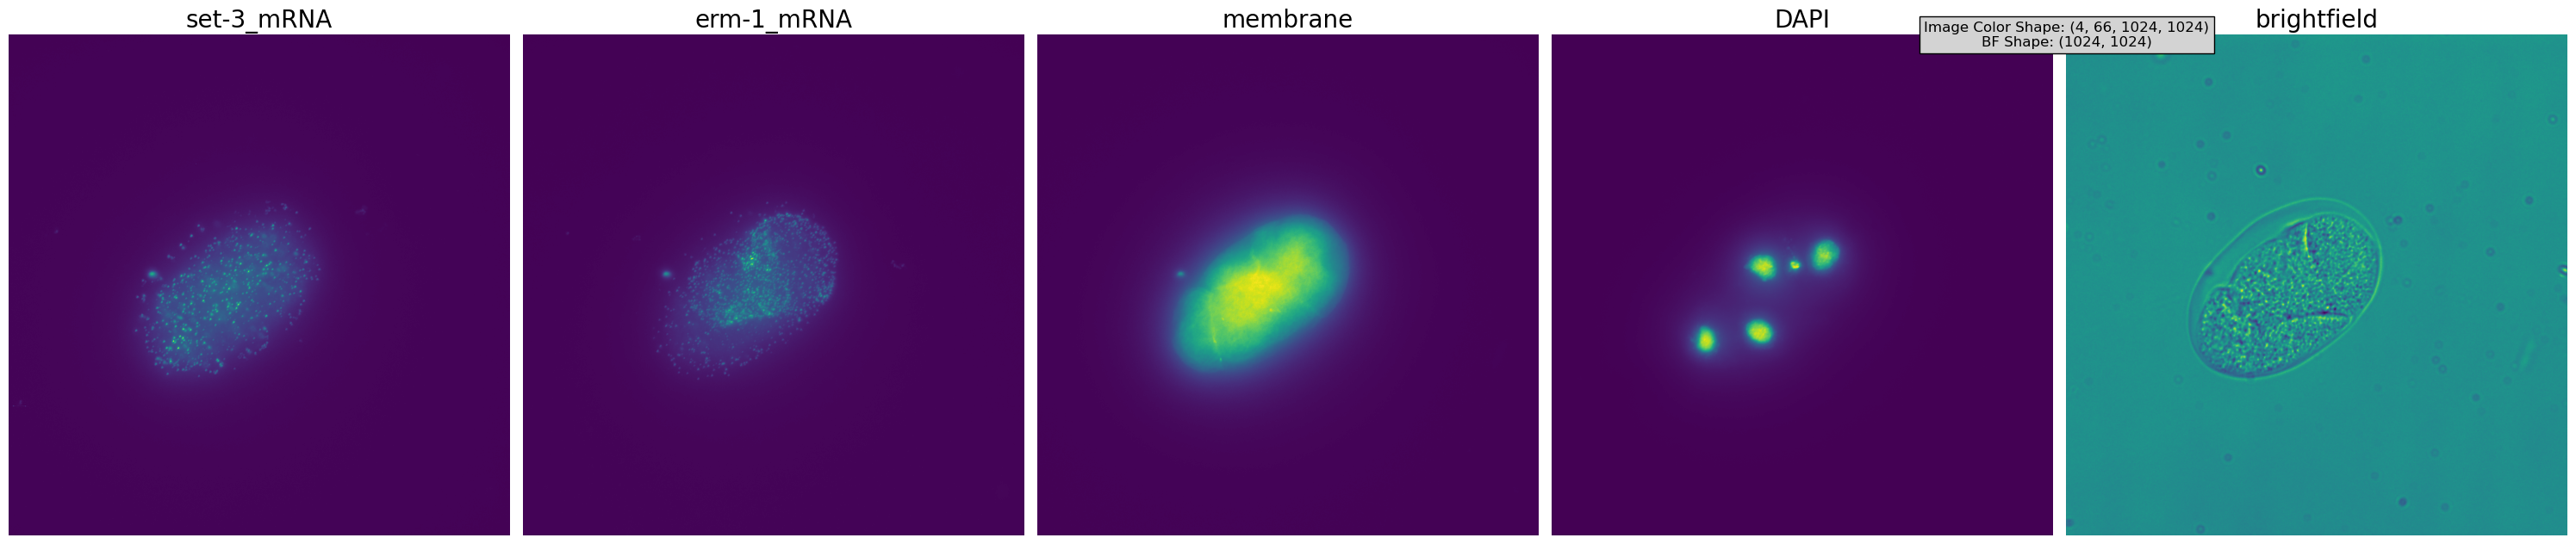

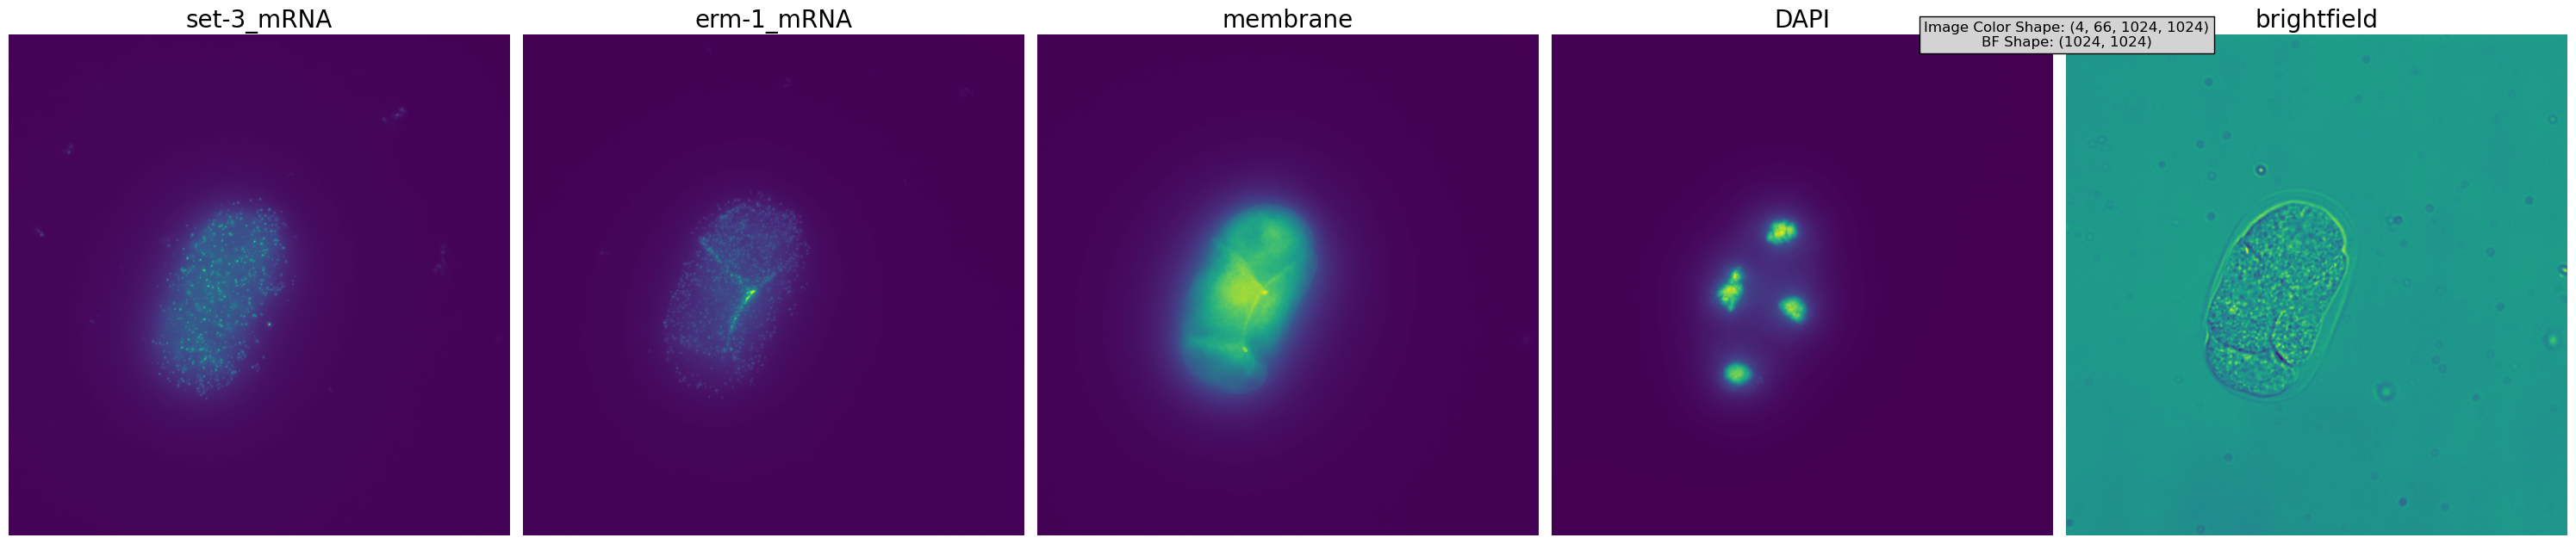

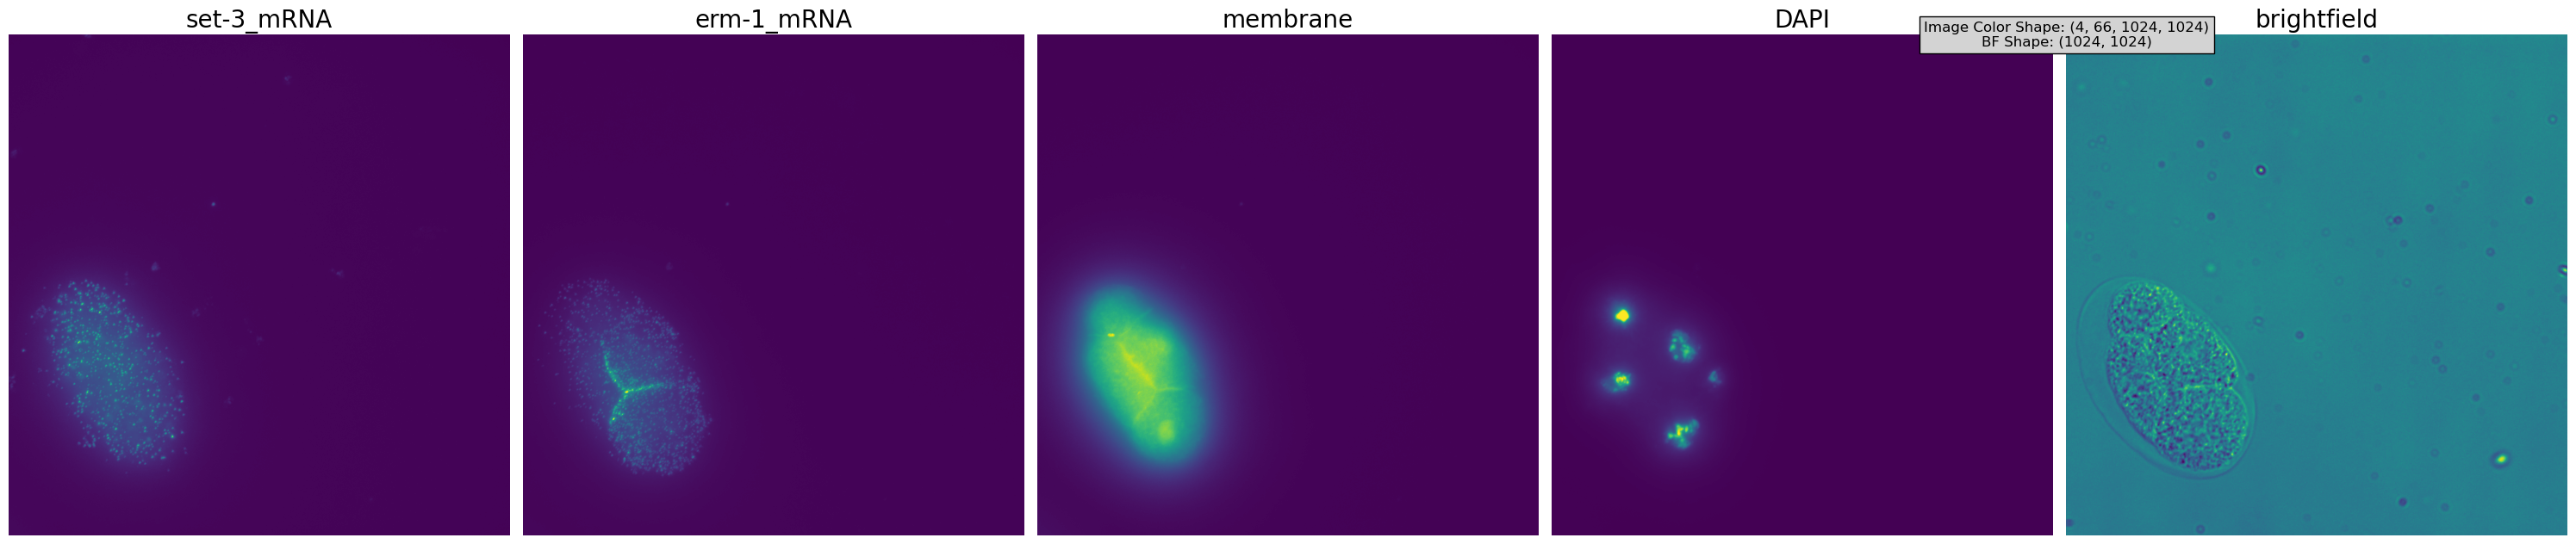

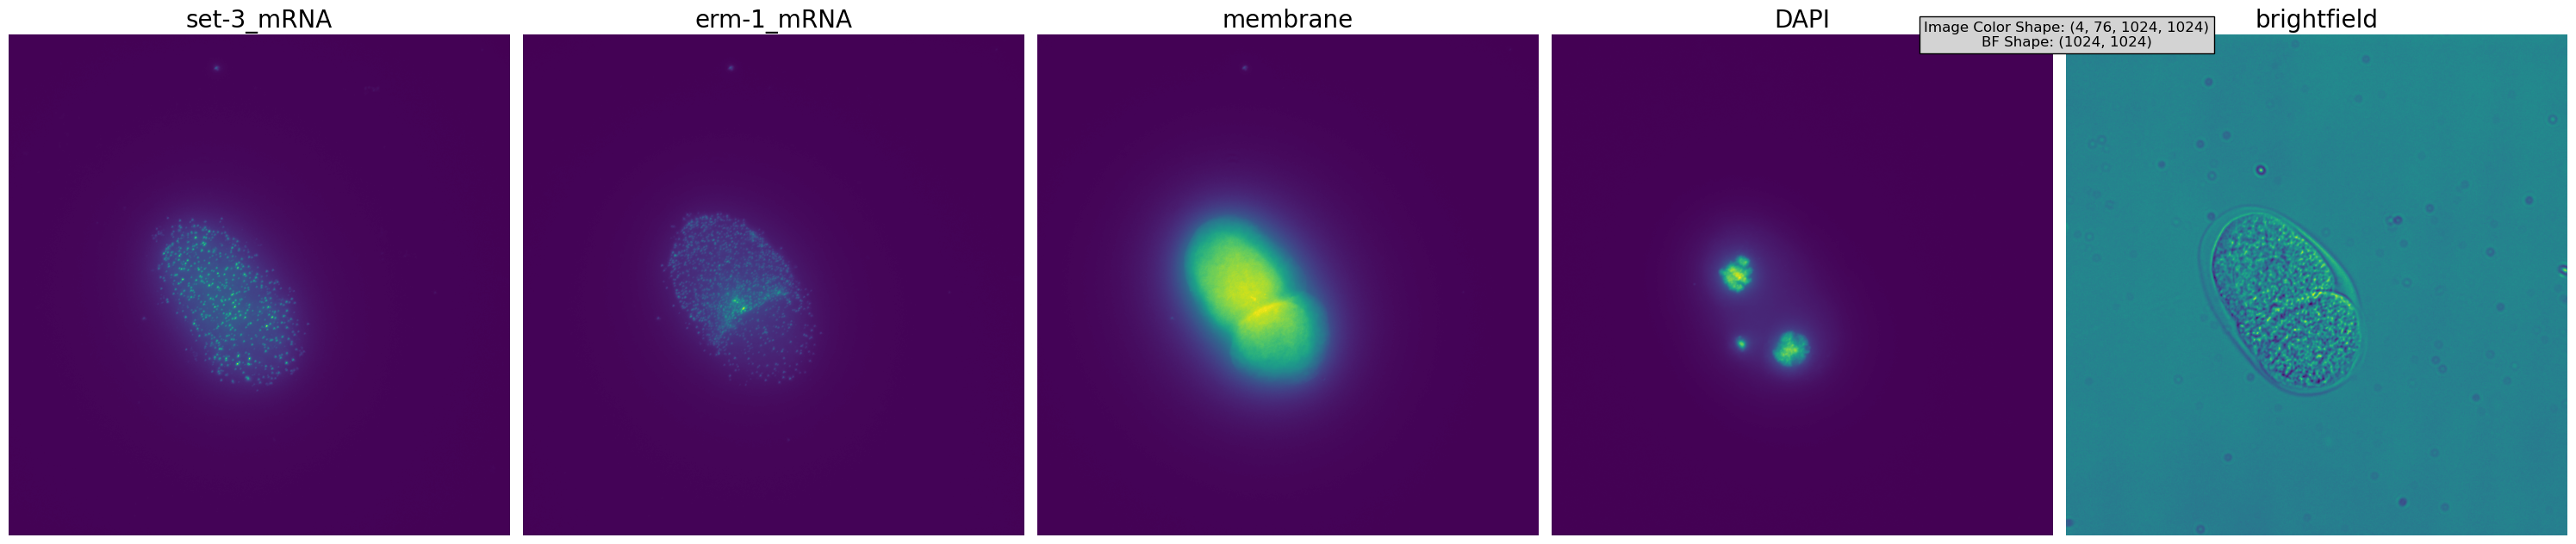

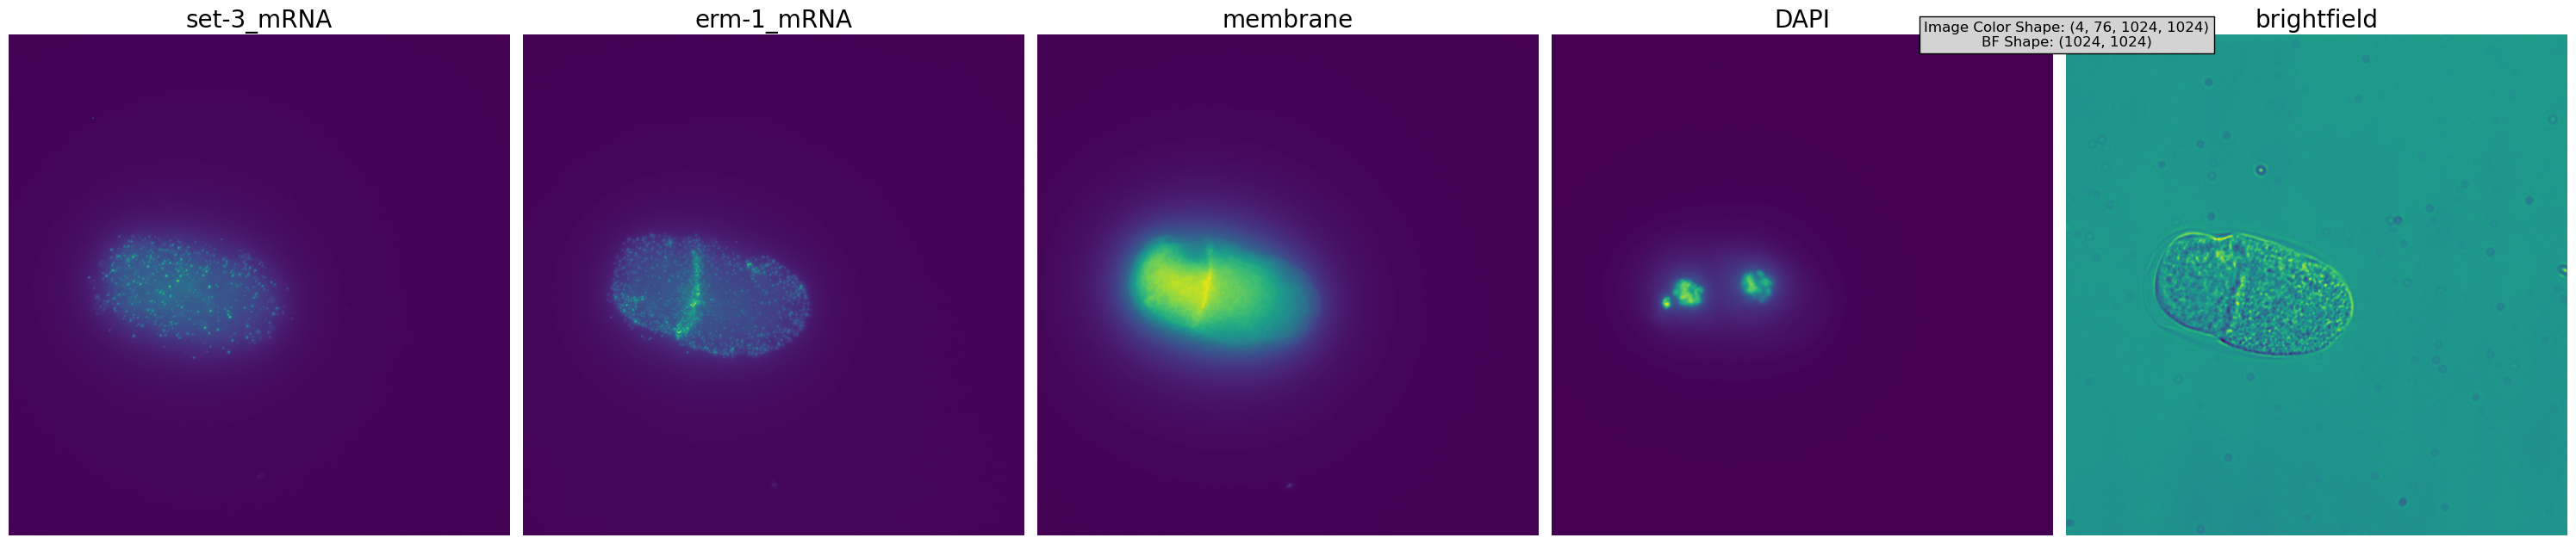

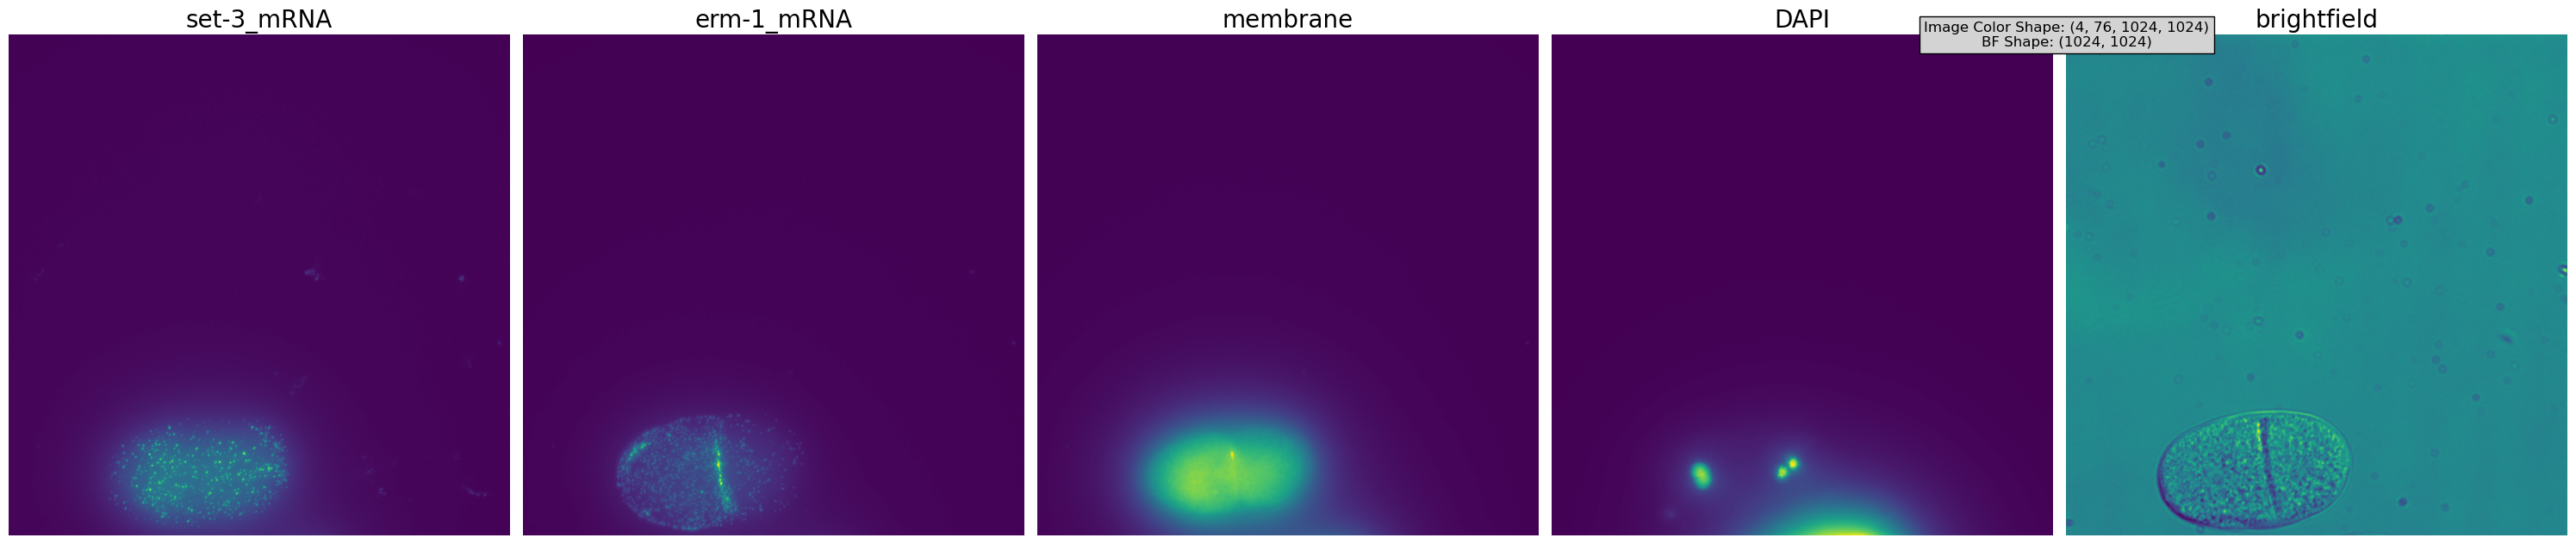

In [4]:
def plot_image(image_colors, bf, Cy5, mCherry, FITC, DAPI, subdirectory_path):
# List of channel names and their corresponding images
    channels = [Cy5, mCherry, FITC, DAPI, brightfield]
    titles = [Cy5, mCherry, FITC, DAPI, brightfield]
    plot_info = f"Image Color Shape: {image_colors.shape}\nBF Shape: {bf.shape}"
    images = [
        np.max(image_colors[0, :, :, :], axis=0) if image_colors[0] is not None and Cy5 else None,
        np.max(image_colors[1, :, :, :], axis=0) if image_colors[1] is not None and mCherry else None,
        np.max(image_colors[2, :, :, :], axis=0) if image_colors[2] is not None and FITC else None,
        np.max(image_colors[3, :, :, :], axis=0) if image_colors[3] is not None and DAPI else None,
        bf if brightfield is not None else None
    ]
    
    # Filter out None entries
    filtered_images = [(img, title) for img, title in zip(images, titles) if img is not None]

    fig, ax = plt.subplots(1, len(filtered_images), figsize=(6 * len(filtered_images), 8))

    # Ensure ax is always iterable, even if there's only one plot
    if len(filtered_images) == 1:
        ax = [ax]

    for i, (img, title) in enumerate(filtered_images):
        ax[i].imshow(img)
        ax[i].set_title(title, size=20)
        ax[i].axis('off')
        

    # Adjust layout if necessary
    plt.tight_layout()
    ax[i].text(0.5, 0.5, plot_info, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='lightgray'))
    ax[i].axis('off')  # Turn off the axis for this colum

    
image_output_directories = []
# Now iterate through all_image_stacks and call plot with the appropriate arguments

for i, stack_image in enumerate(all_image_stacks):
    #if i != 1:
        image_colors = all_image_stacks[i][0]
        bf = all_image_stacks[i][1]
        plot_image(image_colors, bf, Cy5, mCherry, FITC, DAPI, subdirectory_paths[i])
        subdirectory = subdirectories[i]

        # Create image_output_directory. This is where all the output will end up going. 
        image_output_directory = os.path.join(output_directory, subdirectory)
        os.makedirs(image_output_directory, exist_ok=True)
        image_output_directories.append(image_output_directory)
        
        # Generate filename with subdirectory
        image_colors_filename = os.path.join(image_output_directory, f"{subdirectory}_image_colors.png")
    
        plt.savefig(image_colors_filename)
        plt.show()
        



In [5]:
image_output_directories

['/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/02',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/03',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/04',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/05',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/07',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/09',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/10',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/11']

#### 2.1 Segmentation

In [6]:
# Additional functions used for segmentation
def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0
    
def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
    else:
        masks_with_pairs = np.zeros_like(masks_0)
    return masks_with_pairs

def matching_masks(masks_cyto, masks_nuclei):
    n_mask_cyto = np.max(masks_cyto)
    n_mask_nuc = np.max(masks_nuclei)
    new_masks_nuclei = np.zeros_like(masks_cyto)
    reordered_mask_nuclei = np.zeros_like(masks_cyto)
    if (n_mask_cyto>0) and (n_mask_nuc>0):
        for mc in range(1,n_mask_cyto+1):
            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
            for mn in range(1,n_mask_nuc+1):
                mask_paired = False
                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                if mask_paired == True:
                    if np.count_nonzero(new_masks_nuclei) ==0:
                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                    else:
                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
            reordered_mask_nuclei = np.absolute(new_masks_nuclei)
    return reordered_mask_nuclei

def remove_extreme_values(image,min_percentile=0.1, max_percentile=99.5):
    max_val = np.percentile(image, max_percentile)
    min_val = np.percentile(image, min_percentile)
    image [image < min_val] = min_val
    image [image > max_val] = max_val
    return image

def metric_max_cells_and_area( masks):
    n_masks = np.max(masks)
    if n_masks > 1: # detecting if more than 1 mask are detected per cell
        size_mask = []
        for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
            size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
        size_masks_array = np.array(size_mask)
        metric = np.mean(size_masks_array).astype(int) * n_masks
    elif n_masks == 1: # do nothing if only a single mask is detected per image.
        approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
        metric = approximated_radius.astype(int)
    else:  # return zero if no mask are detected
        metric = 0  
    return metric   

def nuclear_segmentation(image_nuclei):
    MIN_CELL_SIZE = 1000
    list_masks_nuclei = []
    list_thresholds = np.arange(0.7,0.95, 0.05)
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_nuclei_binary = image_nuclei.copy()
        max_value_image = np.max(image_nuclei_binary)
        image_nuclei_binary[image_nuclei_binary < max_value_image*tested_ts] = 0
        image_nuclei_binary[image_nuclei_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_nuclei_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_nuclei = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_nuclei[filtered_labels == old_label] = idx
        list_masks_nuclei.append(tested_masks_nuclei)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_nuclei) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    return masks_nuclei

def cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter):
    flow_ts=1
    MIN_CELL_SIZE = 1000
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    if not (second_image_cytosol is None):
        merged_image_cytosol = np.concatenate((image_cytosol[:, :, np.newaxis], second_image_cytosol[:, :, np.newaxis]), axis=2)
        masks_cytosol_unfiltered = model.eval(merged_image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,1])[0]
    else:
        masks_cytosol_unfiltered = model.eval(image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,0])[0]
    filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)
    unique_filtered_cyto = np.unique(filtered_cyto)
    masks_cytosol = np.zeros_like(filtered_cyto)
    for idx, old_label in enumerate(unique_filtered_cyto):
        masks_cytosol[filtered_cyto == old_label] = idx
    return masks_cytosol


In [7]:
def segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter,second_image_cytosol=None):
    # Cytosol segmentation
    masks_cytosol =cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter)
    # Nuclear segmentation
    masks_nuclei = nuclear_segmentation(image_nuclei)
    # reordering nuclei masks
    masks_nuclei = matching_masks(masks_cytosol,masks_nuclei)
    # remove masks without nuclei
    masks_nuclei= remove_lonely_masks(masks_0=masks_nuclei , masks_1=masks_cytosol,is_nuc='nuc')
    masks_cytosol= remove_lonely_masks(masks_0=masks_cytosol , masks_1=masks_nuclei)
    # calculate size of masks
    number_masks_cyto = np.max(masks_cytosol)
    list_masks_cyto_sizes =[]
    for i in range (1, number_masks_cyto+1):
        list_masks_cyto_sizes.append(len(masks_cytosol[masks_cytosol==i]) )
    number_masks_nuc = np.max(masks_nuclei)
    list_masks_nuc_sizes =[]
    for i in range (1, number_masks_nuc+1):
        list_masks_nuc_sizes.append(len(masks_nuclei[masks_nuclei==i]) )
    return masks_nuclei, masks_cytosol,list_masks_nuc_sizes, list_masks_cyto_sizes

In [8]:
# Codes used to segment the nucleus and the cytosol
def segmentation(image_cytosol,image_nuclei, second_image_cytosol=None):
    # removing outliers in image
    image_cytosol = remove_extreme_values(image=image_cytosol,min_percentile=0.1, max_percentile=99.5)
    if not (second_image_cytosol is None):
        second_image_cytosol = remove_extreme_values(image=second_image_cytosol,min_percentile=0.1, max_percentile=99.5)
    image_nuclei = remove_extreme_values(image=image_nuclei,min_percentile=0.1, max_percentile=99.5)
    # Optimization segmentation
    list_masks_nuclei = []
    list_masks_cytosol=[]
    list_masks_nuc_sizes =[]
    list_masks_cyto_sizes=[]
    list_flow_thresholds = np.arange(40, 200, 10)
    array_number_detected_masks = np.zeros(len(list_flow_thresholds))
    for i,tested_ts in enumerate(list_flow_thresholds):
        tested_masks_nuclei, tested_masks_cytosol, tested_list_masks_nuc_sizes, tested_list_masks_cyto_sizes = segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter=tested_ts,second_image_cytosol=second_image_cytosol)
        list_masks_nuclei.append(tested_masks_nuclei)
        list_masks_cytosol.append(tested_masks_cytosol)
        list_masks_nuc_sizes.append(tested_list_masks_nuc_sizes)
        list_masks_cyto_sizes.append(tested_list_masks_cyto_sizes)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_cytosol) + metric_max_cells_and_area( tested_masks_nuclei)
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    masks_cytosol = list_masks_cytosol [selected_index]
    masks_nuc_sizes = list_masks_nuc_sizes[selected_index]
    masks_cyto_sizes = list_masks_cyto_sizes[selected_index]
    
        # Plotting
    color_map = 'Greys_r'
    fig, ax = plt.subplots(1,4, figsize=(14, 4))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(image_nuclei,cmap=color_map)
    ax[1].imshow(masks_nuclei,cmap=color_map)
    ax[2].imshow(image_cytosol,cmap=color_map)
    ax[3].imshow(masks_cytosol,cmap=color_map)
    ax[0].set(title='DAPI'); ax[0].axis('off');ax[0].grid(False)
    ax[1].set(title='mask nuclei'); ax[1].axis('off');ax[1].grid(False)
    ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
    ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)

    
    return masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes

/tmp/ipykernel_3351576/2052647754.py:111: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)


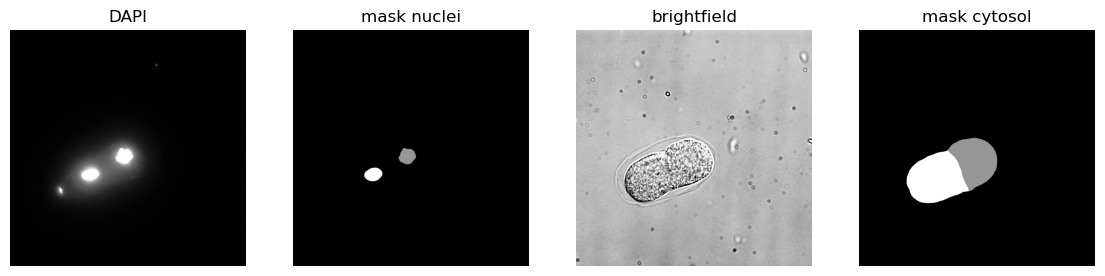

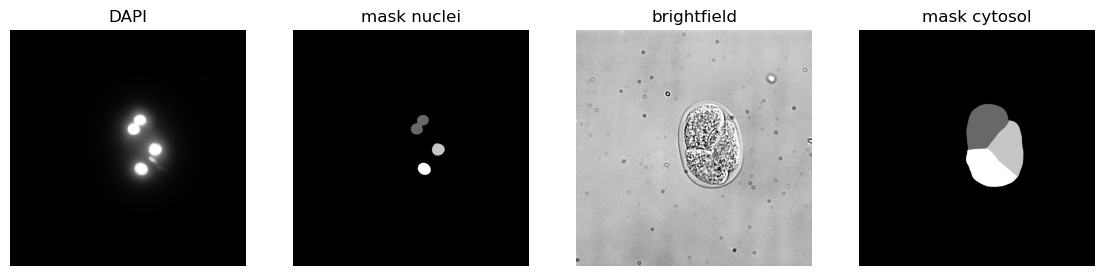

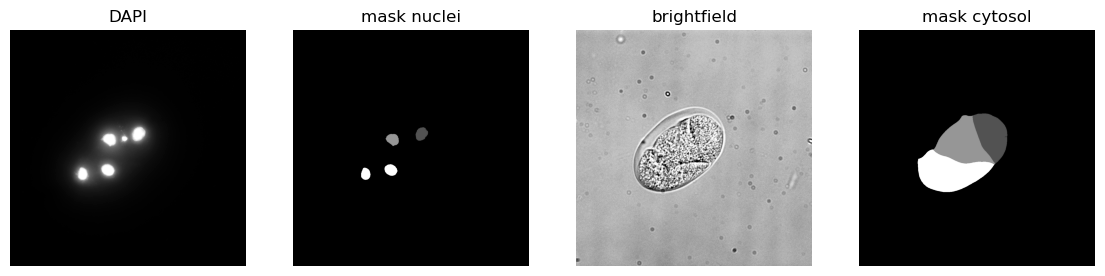

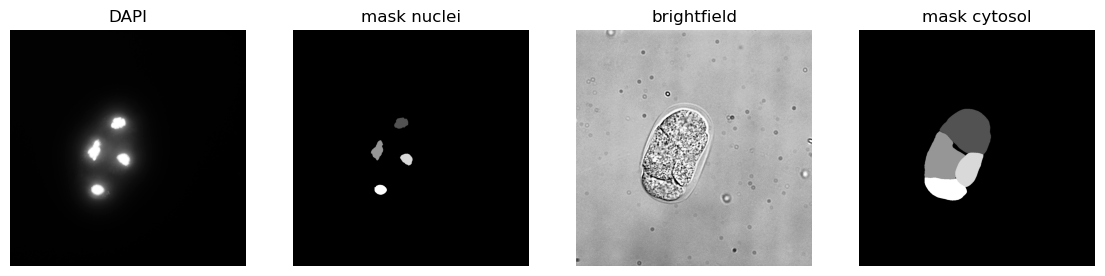

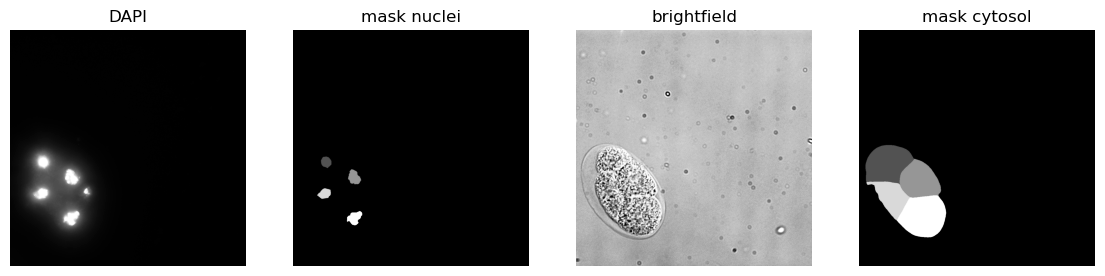

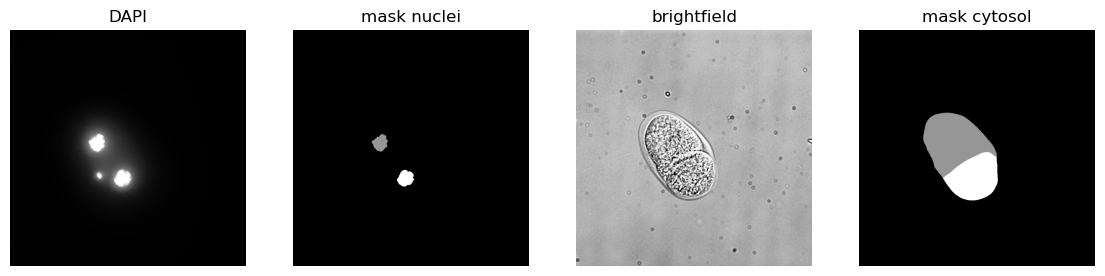

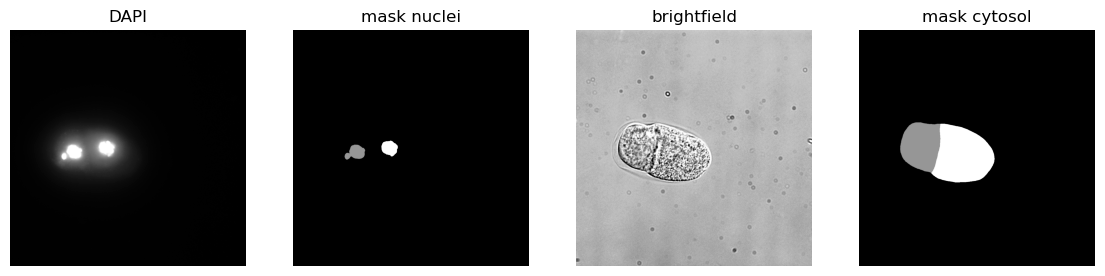

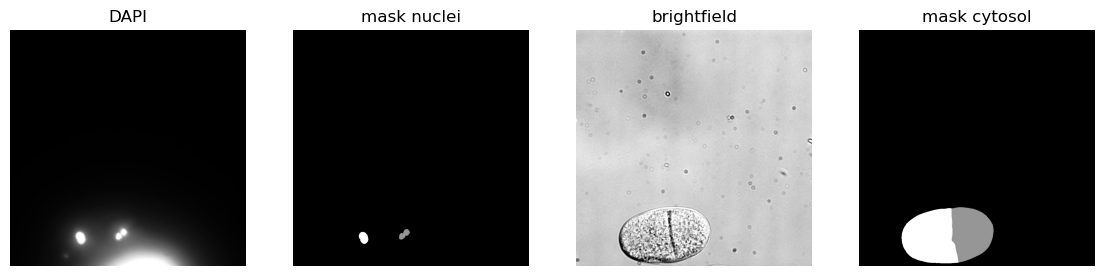

In [9]:
# # Run segmentation functions

# Now iterate through all_image_stacks and call plot with the appropriate arguments
list_all_masks_nuc =[]
list_all_masks_cyto =[]
list_all_nuc_size =[]
list_all_cyto_size=[]


# Iterate through all_image_stacks
for i, stack_image in enumerate(all_image_stacks):
    image_colors = all_image_stacks[i][0]
    image_nuclei = np.max(image_colors[3, :, :, :], axis=0)
    image_cytosol = all_image_stacks[i][1]
    second_image_cytosol = np.max(image_colors[3,:,:,:],axis=0 )
    masks_cytosol, masks_nuclei,list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(image_cytosol,image_nuclei,second_image_cytosol)
    list_all_masks_nuc.append(masks_nuclei)
    list_all_masks_cyto.append(masks_cytosol)
    list_all_nuc_size.append(list_masks_nuc_sizes)
    list_all_cyto_size.append(list_masks_cyto_sizes)
    
    image_output_directory = image_output_directories[i]
    segmentation_filename = os.path.join(image_output_directory, f"{subdirectories[i]}_segmentation.png")

    # Save the figure
    plt.savefig(segmentation_filename)

# Display the last segmentation plot (optional)
# plt.show()


In [10]:
image_output_directories

['/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/02',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/03',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/04',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/05',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/07',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/09',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/10',
 '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/240409_wLP017_L4440/output/11']

[0 1 2]


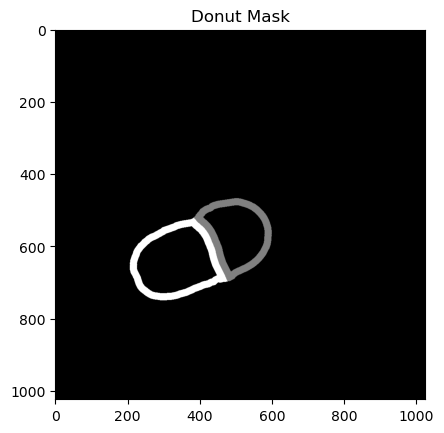

In [11]:
from skimage.morphology import disk, binary_erosion

def generate_border_mask(original_mask, n):
    # Initialize the final mask
    border_mask = np.zeros_like(original_mask)

    for i in np.unique(original_mask):
        if i == 0:
            continue  # Skip the background (assuming it's labeled as 0)
        
        selected_cel = original_mask == i

        # Erode the original mask by n pixels using a disk-shaped structuring element
        selem = disk(n)
        eroded_mask = binary_erosion(selected_cel, selem)

        # Create the border mask by subtracting the eroded mask from the original
        border = selected_cel & ~eroded_mask
        border_mask[border] = i

    return border_mask

# Example usage
sel_mask = list_all_masks_cyto[0]
donut = generate_border_mask(sel_mask.astype(np.uint8), 20)
print(np.unique(donut))

# Plot the donut mask
plt.imshow(donut, cmap='gray')
plt.title('Donut Mask')
plt.show()


In [12]:
# Process each embryo individually
for idx, masks_3d in enumerate(list_all_masks_cyto):
    masks_3d = np.array(masks_3d)

    # Generate the 3D border mask for this embryo
    border_masks_3d = generate_3d_border_mask(masks_3d, 20)

    if border_masks_3d is not None:
        # Plot the 3D outlines for this individual embryo
        plot_3d_border(border_masks_3d, title=f'3D Cell Borders for Embryo {idx+1}')
    else:
        print(f"Skipping Embryo {idx+1}, as it is not a 3D stack.")


NameError: name 'generate_3d_border_mask' is not defined

#### 2.2 Spot detection

In [ ]:
#Codes used for spot detection
# Note: spot radius = Point Spread Function (PSF)

def spot_detection(rna, voxel_size, spot_radius, masks_cytosol, image_output_directory, subdirectory):
    spots, threshold = detection.detect_spots(
        images=rna,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius) 

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=3) 

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

    # Decompose regions by simulating as many spots as possible until we match the original region intensity.
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=rna,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,  # alpha impacts the number of spots per candidate region
        beta=1,  # beta impacts the number of candidate regions to decompose
        gamma=5)  # gamma the filtering step to denoise the image

    # Define clusters
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=626,  # 626
        nb_min_spots=4)

    # Plotting
    print(f"{rna_channel} detection")
    print(f" threshold: {threshold}")
    print("\r spots: {0}".format(spots_post_clustering.shape[0]))
    print("\r clusters: {0}".format(clusters.shape[0]))

    # Elbow plot
    threshold_filename = os.path.join(image_output_directory, subdirectory + '_' + rna_channel +  '_threshold')
    plot.plot_elbow(
        images=rna,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        size_axes=8,
        framesize=(5, 3),
        title=(f"{rna_channel} detection threshold"),
        size_title=12,
        path_output=threshold_filename,
        show=True  # Set show to False to prevent displaying the plot
    )

    # Save the plots in the results folder
    detection_filename = os.path.join(image_output_directory, subdirectory + '_' + rna_channel + '_detection')
    plot.plot_detection(
        image=np.max(rna, axis=0), 
        spots=[spots_post_decomposition, clusters[:, :3]],
        shape=["circle", "polygon"],
        radius=[1.5, 4],
        color=["red", "blue"],
        linewidth=[1, 2],
        fill=[False, True],
        contrast=True,
        framesize=(4, 4),
        title=(f"{rna_channel} detection"),
        path_output=detection_filename,
        show=True
    )

    # Separating and counting the spots in each cell
    number_masks_cyto = np.max(masks_cytosol)
    list_spots_in_each_cell = []
    list_clusters_in_each_cell = []
    for i in range(1, number_masks_cyto + 1):
        temp_cyto_mask = np.zeros_like(masks_cytosol)
        temp_cyto_mask[masks_cytosol == i] = i
        spots_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=spots_post_clustering[:,:3], ndim=3)
        clusters_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=clusters[:,:3], ndim=3)
        list_spots_in_each_cell.append(len(spots_in_region))
        list_clusters_in_each_cell.append(len(clusters_in_region))
        del spots_in_region, clusters_in_region

    return spots_post_clustering, clusters, list_spots_in_each_cell, list_clusters_in_each_cell

In [ ]:
# # PSF calculator 

# # ch1 - mCherry channel
# wavelength_mCherry = 610  # wavelength in nm
# na = 1.42  # numerical aperture

# # Calculate lateral PSF
# fwhm_xy = 0.61 * wavelength_mCherry / na

# # Calculate axial PSF
# refractive_index_medium = 1.515  # refractive index of imaging medium (oil)
# fwhm_z = 2 * refractive_index_medium * wavelength_mCherry / na**2

# # Print the result
# # print(f"Lateral (xy) PSF: {fwhm_xy} nm")

# # print(f"Axial (z) PSF with 60x oil objective: {fwhm_z} nm")


# # ch0 - Cy5 channel
# wavelength_cy5 = 670  # wavelength in nm
# na = 1.42  # numerical aperture for Cy5 channel
# refractive_index_medium_cy5 = 1.515  # refractive index of imaging medium (oil) for Cy5 channel

# # Calculate lateral PSF for Cy5 channel
# fwhm_xy_cy5 = 0.61 * wavelength_cy5 / na

# # Print the result for Cy5 channel
# # print(f"Lateral (xy) PSF for Cy5 channel: {fwhm_xy_cy5} nm")

# # Calculate axial PSF for Cy5 channel
# fwhm_z_cy5 = 2 * refractive_index_medium_cy5 * wavelength_cy5 / na**2

# # Print the result for Cy5 channel
# # print(f"Axial (z) PSF for Cy5 channel with 60x oil objective: {fwhm_z_cy5} nm")



In [ ]:
# PSF calculator 
# wavelength_mCherry = 610  # wavelength in nm -> specified above
# wavelength_cy5 = 670  # wavelength in nm -> specified above
# na = 1.42  # numerical aperture -> specified above
#refractive_index_medium = 1.515  # refractive index of imaging medium (oil)


# #ch1 - mCherry channel
# Calculate lateral PSF
fwhm_xy = 0.61 * wavelength_mCherry / na
# Calculate axial PSF
fwhm_z = 2 * refractive_index_medium * wavelength_mCherry / na**2
# # Print the result
# print(f"Lateral (xy) PSF: {fwhm_xy} nm")
# print(f"Axial (z) PSF with 60x oil objective: {fwhm_z} nm")


# #ch0 - Cy5 channel
# Calculate lateral PSF for Cy5 channel
fwhm_xy_cy5 = 0.61 * wavelength_cy5 / na
# Calculate axial PSF for Cy5 channel
fwhm_z_cy5 = 2 * refractive_index_medium_cy5 * wavelength_cy5 / na**2
# # Print the result for Cy5 channel
# print(f"Lateral (xy) PSF for Cy5 channel: {fwhm_xy_cy5} nm")
# print(f"Axial (z) PSF for Cy5 channel with 60x oil objective: {fwhm_z_cy5} nm")


In [ ]:
# #Call Spot detection function (original, expects both channels)

# # Code to call the spot detection function. 
# voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X
# spot_radius_ch0 = (1409, 340, 340)  # PSF Z,Y,X
# spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X

# # This is creating a list of lists to store the quantification for all images. 
# list_all_spots_in_each_cell_ch0 = []
# list_all_clusters_in_each_cell_ch0 = []
# list_all_spots_in_each_cell_ch1 = []
# list_all_clusters_in_each_cell_ch1 = []

# # Iterate through all_image_stacks and call spot detection with the appropriate arguments
# for i, (stack_image, output_directory, subdirectory) in enumerate(zip(all_image_stacks, image_output_directories, subdirectories)):
#     image_colors = stack_image[0]

#     rna_ch0 = image_colors[0, :, :, :]  # [Z, Y, X, C]
#     rna_channel = Cy5
#     _, _, list_spots_in_each_cell_ch0, list_clusters_in_each_cell_ch0 = spot_detection(
#         rna_ch0, voxel_size, spot_radius_ch0, list_all_masks_cyto[i], output_directory, subdirectory
#     )

#     rna_ch1 = image_colors[1, :, :, :]  # [Z, Y, X, C]
#     rna_channel = mCherry
#     _, _, list_spots_in_each_cell_ch1, list_clusters_in_each_cell_ch1 = spot_detection(
#         rna_ch1, voxel_size, spot_radius_ch1, list_all_masks_cyto[i], output_directory, subdirectory
#     )

#     # Append the results to the corresponding lists
#     list_all_spots_in_each_cell_ch0.append(list_spots_in_each_cell_ch0)
#     list_all_clusters_in_each_cell_ch0.append(list_clusters_in_each_cell_ch0)
#     list_all_spots_in_each_cell_ch1.append(list_spots_in_each_cell_ch1)
#     list_all_clusters_in_each_cell_ch1.append(list_clusters_in_each_cell_ch1)



In [ ]:
#Call spot detection function and store counts in list only if the channels exist

# Code to call the spot detection function. 
voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X
spot_radius_ch0 = (1409, 340, 340)  # PSF Z,Y,X
spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X

# This is creating a list of lists to store the quantification for all images. 
list_all_spots_in_each_cell_ch0 = []
list_all_clusters_in_each_cell_ch0 = []
list_all_spots_in_each_cell_ch1 = []
list_all_clusters_in_each_cell_ch1 = []

# Iterate through all_image_stacks and call spot detection with the appropriate arguments
for i, (stack_image, output_directory, subdirectory) in enumerate(zip(all_image_stacks, image_output_directories, subdirectories)):
    image_colors = stack_image[0]
    
    if Cy5 is not None and image_colors[0,:,:,:] is not None:
        rna_ch0 = image_colors[0, :, :, :]  # [Z, Y, X, C]
        rna_channel = Cy5
        _, _, list_spots_in_each_cell_ch0, list_clusters_in_each_cell_ch0 = spot_detection(
            rna_ch0, voxel_size, spot_radius_ch0, list_all_masks_cyto[i], output_directory, subdirectory
        )

    if mCherry is not None and image_colors[1,:,:,:] is not None:
        rna_ch1 = image_colors[1, :, :, :]  # [Z, Y, X, C]
        rna_channel = mCherry
        _, _, list_spots_in_each_cell_ch1, list_clusters_in_each_cell_ch1 = spot_detection(
            rna_ch1, voxel_size, spot_radius_ch1, list_all_masks_cyto[i], output_directory, subdirectory
        )
        
    list_all_spots_in_each_cell_ch0.append(list_spots_in_each_cell_ch0)
    list_all_clusters_in_each_cell_ch0.append(list_clusters_in_each_cell_ch0)
    list_all_spots_in_each_cell_ch1.append(list_spots_in_each_cell_ch1)
    list_all_clusters_in_each_cell_ch1.append(list_clusters_in_each_cell_ch1)
    
    # Save in each image_output_directory
    image_output_directory = image_output_directories[i]
    subdirectory = subdirectories[i]
    plt.show()
 

    # Append the results to the corresponding lists
    if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None:
        list_all_spots_in_each_cell_ch0.append(list_spots_in_each_cell_ch0)
        
    if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None:
        list_all_clusters_in_each_cell_ch0.append(list_clusters_in_each_cell_ch0)
    
    if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None:
        list_all_spots_in_each_cell_ch1.append(list_clusters_in_each_cell_ch1)
        
    if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None:
        list_all_clusters_in_each_cell_ch1.append(list_clusters_in_each_cell_ch1)

        

In [ ]:
list_spots_in_each_cell_ch0

In [ ]:

# # Initialize empty DataFrame for quantification
# df_quantification = pd.DataFrame()

# # Initialize empty lists for image_names and all_data
# image_names = []
# all_data = []

# # Iterate over subdirectory_paths
# for img_index, subdirectory_path in enumerate(subdirectory_paths):
#     image_name = subdirectory_path.split(os.path.sep)[-1]
#     image_names.append(image_name)

#     # Calculate the sum of each list if they are not None for the current image
#     sum_spots_ch0 = sum(list_spots_in_each_cell_ch0[img_index]) if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None else None
#     sum_clusters_ch0 = sum(list_clusters_in_each_cell_ch0[img_index]) if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None else None

#     sum_spots_ch1 = sum(list_spots_in_each_cell_ch1[img_index]) if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None else None
#     sum_clusters_ch1 = sum(list_clusters_in_each_cell_ch1[img_index]) if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None else None

#     # Check if any sum is not None and skip appending to df_quantification if all are None
#     if any(x is not None for x in [sum_spots_ch0, sum_clusters_ch0, sum_spots_ch1, sum_clusters_ch1]):
#         # Create a data dictionary with summed values
#         data = {
#             'Image ID': image_name,
#         }

#         if sum_spots_ch0 is not None or sum_clusters_ch0 is not None:
#             data[f'{Cy5} mRNA molecules'] = sum_spots_ch0
#             data[f'{Cy5} mRNA clusters'] = sum_clusters_ch0

#         if sum_spots_ch1 is not None or sum_clusters_ch1 is not None:
#             data[f'{mCherry} mRNA molecules'] = sum_spots_ch1
#             data[f'{mCherry} mRNA clusters'] = sum_clusters_ch1

#         # Append the data as a new row to the DataFrame
#         df_quantification = df_quantification.append(data, ignore_index=True)

# # Define the output path for the quantification CSV
# quantification_output = os.path.join(output_folder, 'quantification.csv')

# # Save the entire DataFrame to a single CSV file
# df_quantification.to_csv(quantification_output, index=False)

# # Display the DataFrame (optional)
# df_quantification


In [ ]:
df_quantification = pd.DataFrame()

# Initialize empty lists for image_names and all_data
image_names = []
all_data = []

# Iterate over subdirectory_paths
for img_index, subdirectory_path in enumerate(subdirectory_paths):
    image_name = subdirectory_path.split(os.path.sep)[-1]
    image_names.append(image_name)

    # Calculate sums for each image
    sum_spots_ch0 = sum(list_spots_in_each_cell_ch0) if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None else None
    sum_clusters_ch0 = sum(list_clusters_in_each_cell_ch0) if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None else None
    sum_spots_ch1 = sum(list_spots_in_each_cell_ch1) if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None else None
    sum_clusters_ch1 = sum(list_clusters_in_each_cell_ch1) if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None else None

    # Check if any sum is not None and skip appending to df_quantification if all are None
    if any(x is not None for x in [sum_spots_ch0, sum_clusters_ch0, sum_spots_ch1, sum_clusters_ch1]):
        # Create a data dictionary with summed values
        data = {'Image ID': image_name}
        
        if sum_spots_ch0 is not None or sum_clusters_ch0 is not None:
            data[f'{Cy5} mRNA molecules'] = sum_spots_ch0
            data[f'{Cy5} mRNA clusters'] = sum_clusters_ch0

        if sum_spots_ch1 is not None or sum_clusters_ch1 is not None:
            data[f'{mCherry} mRNA molecules'] = sum_spots_ch1
            data[f'{mCherry} mRNA clusters'] = sum_clusters_ch1

        # Append data to the list
        all_data.append(data)

# Convert the list of data dictionaries to a DataFrame
df_quantification = pd.DataFrame(all_data)

# Save the DataFrame to CSV for each image
for image_name in image_names:
    quantification_output = os.path.join(output_directory, 'quantification_' + image_name + '.csv')
    df_quantification.to_csv(quantification_output, index=False)

# Display the DataFrame (optional)
df_quantification


In [ ]:
# image_names
all_data

In [ ]:
# Export as csv only if channels exist

#It's only storing info from one embryo. Need to iterate through the list. Also need to better specify the image_output_directory

#WHere is the repetition coming from? Is the data in the list corrupted or the loop? cxheck variables -> OK it's the data in "all_data" that is not being stored proprerly. There is some redundancy in that loop.



# Calculate the sum of each list if they are not None
if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None:
    sum_spots_ch0 = sum(list_spots_in_each_cell_ch0)
    sum_clusters_ch0 = sum(list_clusters_in_each_cell_ch0) if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None else None
else:
    sum_spots_ch0 = None
    sum_clusters_ch0 = None

if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None:
    sum_spots_ch1 = sum(list_spots_in_each_cell_ch1)
    sum_clusters_ch1 = sum(list_clusters_in_each_cell_ch1) if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None else None
else:
    sum_spots_ch1 = None
    sum_clusters_ch1 = None


df_quantification = pd.DataFrame()

# Initialize empty lists for image_names and all_data
image_names = []
all_data = []

# Iterate over subdirectory_paths
for img_index, subdirectory_path in enumerate(subdirectory_paths):
    image_name = subdirectory_path.split(os.path.sep)[-1]
    image_names.append(image_name)
    # Check if any sum is not None and skip appending to df_quantification if all are None
    if any(x is not None for x in [sum_spots_ch0, sum_clusters_ch0, sum_spots_ch1, sum_clusters_ch1]):
        # Create a data dictionary with summed values
        data = {
            'Image ID': image_name,
        if sum_spots_ch0 is not None or sum_clusters_ch0 is not None:
            data[f'{Cy5} mRNA molecules'] = sum_spots_ch0
            data[f'{Cy5} mRNA clusters'] = sum_clusters_ch0

        if sum_spots_ch1 is not None or sum_clusters_ch1 is not None:
            data[f'{mCherry} mRNA molecules'] = sum_spots_ch1
            data[f'{mCherry} mRNA clusters'] = sum_clusters_ch1
            }
        # Append data to the list
            all_data.append(data)
# Convert the list of data dictionaries to a DataFrame
df_quantification = pd.DataFrame(all_data)

#         # Concatenate the data as a new row to the DataFrame
#         df_quantification = pd.concat([df_quantification, pd.DataFrame([data])], ignore_index=True)

        quantification_output = os.path.join(output_directory, 'quantification_' + image_name + '.csv')

        # Save the DataFrame to CSV
        df_quantification.to_csv(quantification_output, index=False)

    #     # Optionally, you can assign path_output to quantification_output if needed
    #     path_output = quantification_output

# Display the DataFrame (optional)
df_quantification

In [ ]:
#########################
# Initialize empty lists for image_names and all_data
image_names = []
all_data = []

# Iterate over subdirectory_paths
for img_index, subdirectory_path in enumerate(subdirectory_paths):
    image_name = subdirectory_path.split(os.path.sep)[-1]
    image_names.append(image_name)

    data = {
        'Image ID': image_names[img_index],
        f'{Cy5} molecules': total_spots_ch0[img_index],
        f'{mCherry} molecules': total_spots_ch1[img_index],
        f'{Cy5} clusters': total_clusters_ch0[img_index],
        f'{mCherry} clusters': total_clusters_ch1[img_index],
    }

    # Append data to the list
    all_data.append(data)

# Convert the list of data dictionaries to a DataFrame
df_quantification = pd.DataFrame(all_data)

####################



In [ ]:
# Total abundance csv
# Calculate the sum of each list
total_spots_ch0 = [sum(sublist) for sublist in list_all_spots_in_each_cell_ch0]
total_clusters_ch0 = [sum(sublist) for sublist in list_all_clusters_in_each_cell_ch0]
total_spots_ch1 = [sum(sublist) for sublist in list_all_spots_in_each_cell_ch1]
total_clusters_ch1 = [sum(sublist) for sublist in list_all_clusters_in_each_cell_ch1]

# Initialize an empty DataFrame
df_quantification = pd.DataFrame()

# Initialize empty lists for image_names and all_data
image_names = []
all_data = []

# Iterate over subdirectory_paths
for img_index, subdirectory_path in enumerate(subdirectory_paths):
    image_name = subdirectory_path.split(os.path.sep)[-1]
    image_names.append(image_name)

    data = {
        'Image ID': image_names[img_index],
        f'{Cy5} molecules': total_spots_ch0[img_index],
        f'{mCherry} molecules': total_spots_ch1[img_index],
        f'{Cy5} clusters': total_clusters_ch0[img_index],
        f'{mCherry} clusters': total_clusters_ch1[img_index],
    }

    # Append data to the list
    all_data.append(data)

# Convert the list of data dictionaries to a DataFrame
df_quantification = pd.DataFrame(all_data)

# Set the title attribute (optional)
df_quantification.title = folder_name

# Save as .csv
quantification_output = os.path.join(output_directory, 'quantification_' + folder_name + '.csv')
df_quantification.to_csv(quantification_output, index=False)

# Optionally, you can assign path_output to quantification_output if needed
path_output = quantification_output

# Print the title
print(f'Experiment ID: {folder_name}\n')

# Display the DataFrame (optional)
df_quantification


#### 2.3 Collect spot detection output in a dataframe

In [ ]:
# Create a dictionary with the given data
list_all_spots_ch0 = total_spots_ch0
list_all_spots_ch1 = total_spots_ch1

data = {
    'mRNA': [Cy5] * len(list_all_spots_ch0) + [mCherry] * len(list_all_spots_ch1),
    'number_spots': list_all_spots_ch0 + list_all_spots_ch1
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a violin plot, boxplot, and swarmplot
sns.violinplot(x="mRNA", y="number_spots", hue="mRNA", data=df, inner=None, color="lightgray", density_norm='width', palette="pastel", legend=False)
sns.boxplot(x="mRNA", y="number_spots", data=df, color="gray", width=0.3, showfliers=False)
sns.swarmplot(x="mRNA", y="number_spots", data=df, color="black", size=4, alpha=0.7)

# Include folder_name in the title
plt.title(f"mRNA Abundance in {folder_name}")

# Customize axis labels
plt.xlabel("")
plt.ylabel("Total Number of mRNA Spots")

# Save as .png
# Define the output path before saving the PNG
violin_output = os.path.join(output_directory, f'violin_{folder_name}.png')
plt.savefig(violin_output)

# Display the plot
plt.show()


### 3. Analysis of Special Features

In [ ]:
# DO I need to start with the heatmaps? I think so becasuse of the grid-like structure.. Lists could also be a good way fo doing the heatmaps for all images actually


# Goal for today 240808 -> Today I want to loop all the images through each special feature function. For this I will need a list
    # of coordinates per channel per image? not sure yet, tbd. 
    
    # I also want to append the special feature results to the final df


In [ ]:
#OK this is the function for a single embryo. First I need a list of spots_post_clustering_ch0 (the actual array in 2D with 4 columns). 
#I need one per image, per channel stored in independent lists I can match together
#



def create_heatmap(spots_x, spots_y, masks_cytosol, masks_nuclei, output_filename, title_suffix, grid_width=80, grid_height=80):
    # Calculate the width and height of each grid cell
    img_width, img_height = masks_cytosol.shape[1], masks_cytosol.shape[0]
    cell_width = img_width / grid_width
    cell_height = img_height / grid_height

    # Create an empty grid to store the spot counts
    grid = np.zeros((grid_height, grid_width), dtype=int)

    # Count spots in each grid cell
    for x, y in zip(spots_x, spots_y):
        # Determine which grid cell the spot belongs to
        cell_x = int(x / cell_width)
        cell_y = int(y / cell_height)

        # Increment the count in the corresponding grid cell
        if 0 <= cell_x < grid_width and 0 <= cell_y < grid_height:
            grid[cell_y, cell_x] += 1

    # Create a heatmap
    plt.imshow(masks_cytosol, cmap='gray')  # Display the original image
    plt.imshow(masks_nuclei, cmap='gray')
    plt.imshow(grid, cmap='CMRmap', alpha=1, interpolation='nearest')  # Overlay the heatmap
    plt.title(f'mRNA Abundance Heatmap ({title_suffix})')
    plt.axis('off')

    # Create a vertical color bar
    cbar = plt.colorbar(orientation='vertical', shrink=0.5)  # Adjust the shrink parameter to make it smaller
    cbar.ax.text(1, 1.05, 'Higher\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.ax.text(1, -0.19, 'Lower\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.set_ticks([])

    # Save the plots in the results folder
    plt.savefig(output_filename)
    plt.show()

# Generate heatmap for channel 0 (Cy5) if spots_post_clustering_ch0 is defined
if 'spots_post_clustering_ch0' in locals():
    spots_x_ch0 = spots_post_clustering_ch0[:, 2]
    spots_y_ch0 = spots_post_clustering_ch0[:, 1]
    create_heatmap(spots_x_ch0, spots_y_ch0, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{Cy5}_heatmap.png'), Cy5)

# Generate heatmap for channel 1 (mCherry) if spots_post_clustering_ch1 is defined
if 'spots_post_clustering_ch1' in locals():
    spots_x_ch1 = spots_post_clustering_ch1[:, 2]
    spots_y_ch1 = spots_post_clustering_ch1[:, 1]
    create_heatmap(spots_x_ch1, spots_y_ch1, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{mCherry}_heatmap.png'), mCherry)



In [ ]:
# list_all_spots_in_each_cell_ch0

#### 3.1 mRNA-mRNA colocalization

In [ ]:
# The stategy here will be to store all the 2D arrays in lists and supperpone the lists...

In [ ]:
# Clean arrays to visualize the data in 3D

ch0_array = spots_post_clustering_ch0
# Check if the array has exactly 4 columns
if ch0_array.shape[1] == 4 :
    # Remove the last column
    ch0_array = ch0_array[:, :-1]
    print("Last column removed.")
else:
    # Keep the array unchanged
    ch0_array  = ch0_array
    print("Array unchanged.")

# Display the cleaned array
print("Cleaned ch0 array:")
print(ch0_array)


print("\n")



# Original array (example)
ch1_array = spots_post_clustering_ch1
# Check if the array has exactly 4 columns 
if ch1_array.shape[1] == 4 :
    # Remove the last column
    ch1_array = ch1_array[:, :-1]
    print("Last column removed.")
else:
    # Keep the array unchanged
    ch1_array = ch1_array
    print("Array unchanged.")

# Display the cleaned array
print("Cleaned ch1 array:")
print(ch1_array)



In [ ]:
#mRNA channel image for background
rna_max_ch0 = np.max(image_colors[0, :, :, :], axis=0)  # Cy5 channel
rna_max_ch1 = np.max(image_colors[1, :, :, :], axis=0)  # mCherry channel


#670 channel dual spot overlay 
print(f"spot detection overlay on {Cy5} image")
print(f"{Cy5} spot count: {ch0_array.shape}")

plot.plot_detection(
    rna_max_ch0,
    spots=[ch0_array, ch1_array], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, 
    contrast=True, 
    framesize=(10, 5)
)



#610 channel dual spot overlay 
print(f"spot detection overlay on {mCherry} image")
print(f"{mCherry} spot count: {ch1_array.shape}")

plot.plot_detection(
    rna_max_ch1,
    spots=[ch0_array, ch1_array], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, 
    contrast=True, 
    framesize=(10, 5)
)



# plot
plot.plot_detection(
    rna_max_ch0,
    spots=ch0_array, 
    radius=1, 
    color="red",
    title=f"Red = {Cy5}",
    linewidth=3, contrast=True, framesize=(10, 5))



In [ ]:
# Perform co-localization detection
voxel_size = (1448, 450, 450)
threshold = 5
colocalized_spots = []
(
    colocalized_spots_ch0, 
    colocalized_spots_ch1, 
    distances, 
    indices_1, 
    indices_2, 
    threshold
) = multistack.detect_spots_colocalization(
    spots_1=ch0_array, #edit here to calculate co-localizatin with other things.. input coordinates here 
    spots_2=ch1_array,
    voxel_size=voxel_size,
    threshold=5,  # Pass the manually set threshold
    return_indices=True,
    return_threshold=True  # To get the threshold value
)


# Print details of the co-localized spots
print("colocalized spots")
print(f"\r distances: {distances.shape}")
# print(f"\r threshold: {threshold:0.2f} nm")

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[colocalized_spots_ch0, colocalized_spots_ch1], 
    radius=2, 
    color=["red", "purple"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

#### 3.2 mRNA-nuclei colocalization (transcription sites)

In [ ]:
# Same but with nuclei mask. is this also a 2d array? cant remember

In [ ]:
# nuc_max = np.max(image_colors[1, :, :, :], axis=0)  # mCherry channel

#Code to visualize colocalization with nuclei
mask = masks_nuclei
coord = ch0_array
ndim = 3

spots_in, spots_out = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside nuclei)")
print("\r shape: {0}".format(spots_in.shape))

print("detected spots (outside nuclei)")
print("\r shape: {0}".format(spots_out.shape))



# # plot
# plot.plot_detection(
#     image_nuclei,
#     spots=[spots_in, spots_out], 
#     radius=1, 
#     color=["red", "blue"],
#     title=f"Red = {Cy5} | Blue = {mCherry}",
#     linewidth=3, contrast=True, framesize=(10, 5))

# plot
plot.plot_detection(
    mask,
    spots=spots_in, 
    radius=1, 
    color="red",
    title=f"Red = {mCherry} in nuclei",
    linewidth=3, contrast=True, framesize=(10, 5))

# plot
plot.plot_detection(
    image_nuclei,
    spots=spots_out, 
    radius=1, 
    color="blue",
    title=f"Red = {mCherry} in nuclei",
    linewidth=3, contrast=True, framesize=(10, 5))


# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_in, spots_out], 
    radius=1, 
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

#### 3.3 mRNA-p granule colocalization (sites of translation repression?)

In [ ]:
# Same but with granules masks

In [ ]:
#p-granule mask for co-localization

image_pgranules = np.max(image_colors[2, :, :, :], axis=0)

def mask_pgranule(image_pgranules):
    MIN_CELL_SIZE = 1
    list_masks_pgranules = []
    list_thresholds = np.arange(0.7,0.95, 0.05)
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_pgranules_binary = image_pgranules.copy()
        max_value_image = np.max(image_pgranules_binary)
        image_pgranules_binary[image_pgranules_binary < max_value_image*tested_ts] = 0
        image_pgranules_binary[image_pgranules_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_pgranules_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_pgranules = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_pgranules[filtered_labels == old_label] = idx
        list_masks_pgranules.append(tested_masks_pgranules)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_pgranules) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_pgranules = list_masks_pgranules [selected_index]
    return masks_pgranules

masks_pgranules = mask_pgranule(image_pgranules)


# Plotting
color_map = 'Greys_r'
fig, ax = plt.subplots(1,4, figsize=(14, 4))
# Plotting the heatmap of a section in the image
ax[0].imshow(image_pgranules,cmap=color_map)
ax[1].imshow(masks_pgranules,cmap=color_map)
ax[2].imshow(image_cytosol,cmap=color_map)
ax[3].imshow(masks_cytosol,cmap=color_map)
ax[0].set(title='p granules'); ax[0].axis('off');ax[0].grid(False)
ax[1].set(title='mask p granules'); ax[1].axis('off');ax[1].grid(False)
ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)



In [ ]:
#Code to visualize colocalization with p granules

mask = masks_pgranules
coord = ch1_array
ndim = 3

spots_in_pgranules, spots_out_pgranules = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside p-granules)")
print("\r shape: {0}".format(spots_in_pgranules.shape))
print("\r dtype: {0}".format(spots_in_pgranules.dtype), "\n")
print("detected spots (outside p-granules)")
print("\r shape: {0}".format(spots_out_pgranules.shape))
print("\r dtype: {0}".format(spots_out_pgranules.dtype))


# plot
plot.plot_detection(
    mask,
    spots=spots_in_pgranules, 
    radius=1, 
    color="red",
    title="Red = mRNA in p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=spots_out_pgranules, 
    radius=1, 
    color="blue",
    title="Red = mRNA in p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))


# # plot
# plot.plot_detection(
#     rna_max_ch1,
#     spots=[spots_in_pgranules, spots_out_pgranules], 
#     radius=2, 
#     color=["red", "blue"],
#     title=f"Red = {Cy5} | Blue = {mCherry}",
#     linewidth=3, contrast=True, framesize=(10, 5))

In [ ]:
#Code to visualize colocalization with p granules

mask = donut
coord = ch1_array
ndim = 3

spots_in_pgranules, spots_out_pgranules = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside p-granules)")
print("\r shape: {0}".format(spots_in_pgranules.shape))
print("\r dtype: {0}".format(spots_in_pgranules.dtype), "\n")
print("detected spots (outside p-granules)")
print("\r shape: {0}".format(spots_out_pgranules.shape))
print("\r dtype: {0}".format(spots_out_pgranules.dtype))


# plot
plot.plot_detection(
    mask,
    spots=spots_in_pgranules, 
    radius=1, 
    color="red",
    title="Red = mRNA in p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=spots_out_pgranules, 
    radius=1, 
    color="blue",
    title="Red = mRNA in p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))


# # plot
# plot.plot_detection(
#     rna_max_ch1,
#     spots=[spots_in_pgranules, spots_out_pgranules], 
#     radius=2, 
#     color=["red", "blue"],
#     title=f"Red = {Cy5} | Blue = {mCherry}",
#     linewidth=3, contrast=True, framesize=(10, 5))

#### Create html report

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os

def collect_png_files(directory):
    png_files = []
    for file in os.listdir(directory):
        if file.endswith('.png'):
            png_files.append(os.path.join(directory, file))
    return png_files

def create_pdf_report(pdf_filename, image_filenames):
    c = canvas.Canvas(pdf_filename, pagesize=letter)

    # Add images to the PDF
    y_offset = 50
    for image_filename in image_filenames:
        c.drawInlineImage(image_filename, x=50, y=y_offset, width=500, height=300)
        y_offset += 320  # Adjust the y_offset to leave space between images

    c.save()

# Directory path
directory_path = image_output_directory

# Get PNG files in the directory
png_files = collect_png_files(directory_path)

# PDF filename
pdf_filename = "output_report.pdf"

# Create PDF report with embedded images
create_pdf_report(pdf_filename, png_files)

print(f"PDF report generated at: {pdf_filename}")


In [ ]:
import numpy as np
# ZYX, if it is a cluster
# #plt.scatter(spots_post_clustering_ch1[:,2], spots_post_clustering_ch1[:,1], s=1,c='g')

# Define the grid parameters
grid_width = 80  # Number of grid cells in the x-direction
grid_height = 80  # Number of grid cells in the y-direction

# Calculate the width and height of each grid cell
img_width, img_height = masks_cytosol.shape[1], masks_cytosol.shape[0]
cell_width = img_width / grid_width
cell_height = img_height / grid_height

# Create grid lines
# for i in range(1, grid_width):
#     plt.axvline(cell_width * i, color='red', linestyle='--', linewidth=1)

# for j in range(1, grid_height):
#     plt.axhline(cell_height * j, color='red', linestyle='--', linewidth=1)


# Create an empty grid to store the spot counts
grid = np.zeros((grid_height, grid_width), dtype=int)

# Scatter plot for spots_x_ch0 and spots_y_ch0
spots_x = spots_post_clustering_ch0[:, 2]
spots_y = spots_post_clustering_ch0[:, 1]

# Count spots in each grid cell
for x, y in zip(spots_x, spots_y):
    # Determine which grid cell the spot belongs to
    cell_x = int(x / cell_width)
    cell_y = int(y / cell_height)

    # Increment the count in the corresponding grid cell
    if 0 <= cell_x < grid_width and 0 <= cell_y < grid_height:
        grid[cell_y, cell_x] += 1

# Create a heatmap
plt.imshow(masks_cytosol, cmap='gray')  # Display the original image
plt.imshow(masks_nuclei, cmap='gray')
plt.imshow(grid, cmap='CMRmap', alpha=1, interpolation='nearest')  # Overlay the heatmap
plt.title('mRNA Abundance Heatmap')
plt.axis('off')

# Create a vertical color bar
cbar = plt.colorbar(orientation='vertical', shrink=0.5)  # Adjust the shrink parameter to make it smaller
cbar.ax.text(1, 1.05, 'Higher\nlevels', transform=cbar.ax.transAxes, ha='center')
cbar.ax.text(1, -0.19, 'Lower\nlevels', transform=cbar.ax.transAxes, ha='center')
cbar.set_ticks([])


# Save the plots in the results folder
plt.savefig(os.path.join(output_folder, 'heatmap_ch1.png'))
plt.show()
#other palettes that look good: turbo, jet, gnuplot, gnuplot2, CMRmap,pink

